In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import AFAI_library as afai
import AFAI_library_torch as afai_cuda
import AFAI_parallelGPU as afai_parallel
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
# from mpl_toolkits.mplot3d import Axes3D
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
%autoreload 2

In [4]:
torch.device('cuda:0')
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [5]:
period = 2
hopping = - 3 * np.pi/(2)
hopping1 = - np.pi/(2)
hopping2 = - 3 * np.pi/(2)
hopping3 = - 5 * np.pi/(2)
model_test = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping, 2,2)
model = afai_cuda.tb_floquet_tbc_cuda(period, 1, hopping, 2,2)
np.set_printoptions(linewidth=300)

In [6]:
model_pest = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=30, device='cuda:0')
model_pest2 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=30, device='cuda:0')
model_pest3 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=30, device='cuda:0')

In [7]:
kx = torch.linspace(0, 2*torch.pi/model_pest2.aa, 100)

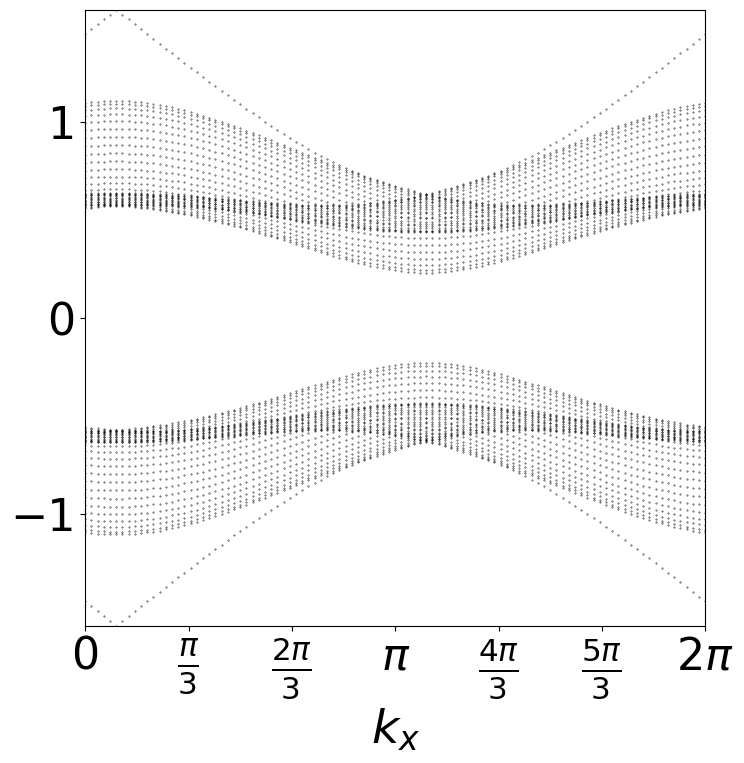

(tensor([[-1.4467, -1.0949, -1.0806,  ...,  1.0806,  1.0949,  1.4467],
         [-1.4715, -1.0985, -1.0842,  ...,  1.0842,  1.0985,  1.4715],
         [-1.4963, -1.1014, -1.0870,  ...,  1.0870,  1.1014,  1.4963],
         ...,
         [-1.3973, -1.0852, -1.0711,  ...,  1.0711,  1.0852,  1.3973],
         [-1.4220, -1.0904, -1.0762,  ...,  1.0762,  1.0904,  1.4220],
         [-1.4467, -1.0949, -1.0806,  ...,  1.0806,  1.0949,  1.4467]],
        device='cuda:0', dtype=torch.float64),
 tensor([[-0.9694+0.2456j, -0.5801+0.8145j, -0.5566+0.8308j,  ...,
          -0.5566-0.8308j, -0.5801-0.8145j, -0.9694-0.2456j],
         [-0.9803+0.1974j, -0.5861+0.8102j, -0.5626+0.8267j,  ...,
          -0.5626-0.8267j, -0.5861-0.8102j, -0.9803-0.1974j],
         [-0.9889+0.1485j, -0.5908+0.8068j, -0.5673+0.8235j,  ...,
          -0.5673-0.8235j, -0.5908-0.8068j, -0.9889-0.1485j],
         ...,
         [-0.9404+0.3400j, -0.5643+0.8256j, -0.5408+0.8411j,  ...,
          -0.5408-0.8411j, -0.5643-0.8256j, 

In [8]:
model_pest2.quasienergy_eigenstates(model_pest2.T, 100, 100, plot=True, pbc='x')

Evolve one period
steps_per_segment 40000
Evolve one period
steps_per_segment 34740
Evolve one period
steps_per_segment 30172
Evolve one period
steps_per_segment 26205
Evolve one period
steps_per_segment 22759
Evolve one period
steps_per_segment 19766
Evolve one period
steps_per_segment 17167
Evolve one period
steps_per_segment 14910
Evolve one period
steps_per_segment 12949
Evolve one period
steps_per_segment 11247
Evolve one period
steps_per_segment 9768
Evolve one period
steps_per_segment 8483
Evolve one period
steps_per_segment 7368
Evolve one period
steps_per_segment 6399
Evolve one period
steps_per_segment 5557
Evolve one period
steps_per_segment 4827
Evolve one period
steps_per_segment 4192
Evolve one period
steps_per_segment 3641
Evolve one period
steps_per_segment 3162
Evolve one period
steps_per_segment 2746
Evolve one period
steps_per_segment 2385
Evolve one period
steps_per_segment 2071
Evolve one period
steps_per_segment 1799
Evolve one period
steps_per_segment 1562
Evolve

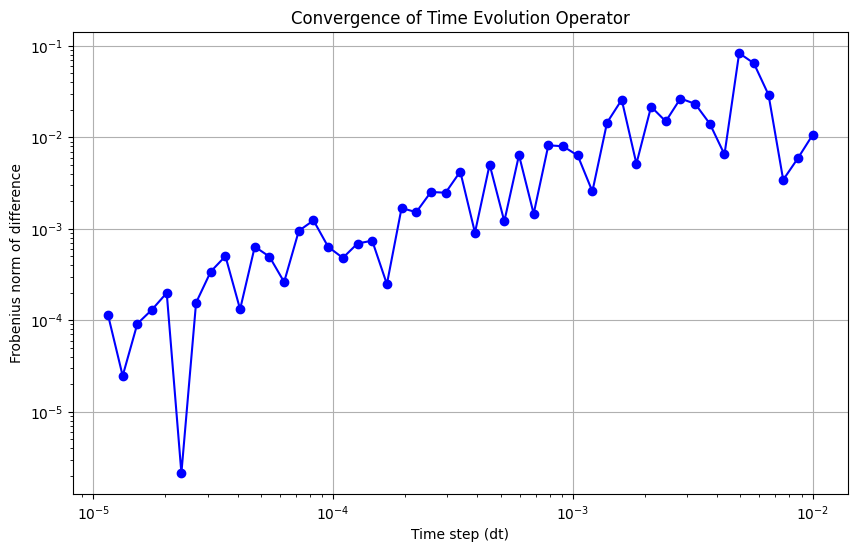

Smallest difference between consecutive dt values: 2.1324074782941364e-06


In [51]:
def convergence_test(t_final, vd, num_dt_values=50, min_dt=1e-5, max_dt=1e-2):
    # Parameters for the test
    tbc = "x"
    rotation_angle = np.pi/4
    theta_x = 0
    theta_y = 0

    # Generate a logarithmically spaced array of dt values
    dt_values = np.logspace(np.log10(min_dt), np.log10(max_dt), num_dt_values)

    # Store results
    results = []

    # Compute evolution for each dt
    for dt in dt_values:
        U = model_test.time_evol_op(t_final, dt, tbc, vd, rotation_angle, theta_x, theta_y)
        # Extract the first (and only) element if U is batched
        if U.dim() == 3:
            U = U[0]
        results.append(U.cpu().numpy())
    print(results)
    # Compute differences between consecutive results
    differences = []
    for i in range(1, len(results)):
        diff = np.linalg.norm(results[i] - results[i-1], ord='fro')
        differences.append(diff)
    print(differences)
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.loglog(dt_values[1:], differences, 'bo-')
    plt.xlabel('Time step (dt)')
    plt.ylabel('Frobenius norm of difference')
    plt.title('Convergence of Time Evolution Operator')
    plt.grid(True)
    plt.show()

    # Return the smallest difference for reference
    return min(differences)

# Usage:
# Assuming you have your model instance as 'model'
t_final = 3* period  # or any other final time you want to test
vd = 1.0  # or any other vd value you want to test
min_difference = convergence_test(t_final, vd)
print(f"Smallest difference between consecutive dt values: {min_difference}")

In [52]:
nn = torch.arange(2 + 1)
energy = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64)
complex_exponent = 1j * energy * nn.unsqueeze(1) * 3

In [53]:
print(complex_exponent)

tensor([[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+3.j, 0.+6.j, 0.+9.j],
        [0.+6.j, 0.+12.j, 0.+18.j]], dtype=torch.complex128)


In [59]:
t = 5 % 4
print(t)

1


In [72]:
def time_evolution_operator_pbc1(t, kx, ky):
        '''Time evolution operator for time 0 ≤ t ≤ T with a specified number of steps per T/5 segment'''
        '''Support not only scalar (kx, ky, t) pair
        but also batch processing for multiple (kx, ky, t) pairs: vectorization of kx, ky, and t: 1D tensors
        the output shape is then (N_kx, N_ky, N_t, nx*ny, nx*ny)'''
        
        # Determine if inputs are batched
        is_batch = isinstance(kx, torch.Tensor) and isinstance(ky, torch.Tensor) and kx.dim() + ky.dim() > 1

        if is_batch:
            batch_size = kx.shape[0]  # Total number of (kx, ky) pairs
            kx = kx.reshape(-1)  # Flatten kx to 1D
            print(kx)
            ky = ky.reshape(-1)  # Flatten ky to 1D
            print(ky)
            if isinstance(t, torch.Tensor) and t.dim() > 0:
                t = t.reshape(-1)
        else:
            batch_size = 1
        print(batch_size)
        # Reshape inputs for batch processing
        if isinstance(kx, torch.Tensor):
            kx = kx.view(batch_size, 1)
            print(kx)
        else:
            kx = torch.full((batch_size, 1), kx)
            print(kx)

        if isinstance(ky, torch.Tensor):
            ky = ky.view(batch_size, 1)
            print(ky)
        else:
            ky = torch.full((batch_size, 1), ky)
            print(ky)

        if isinstance(t, torch.Tensor):
            t = t.view(batch_size, 1)
            print(t)
        else:
            t = torch.full((batch_size, 1), t)
            print(t)
        return kx, ky, t

In [6]:
model = afai.tb_floquet_pbc(period, 1, hopping, 1)

In [12]:
model_pest = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping, 1)

In [10]:
torch.cuda.empty_cache()

In [102]:
N_div = 5
teo = model_pest.eigen_grid(N_div,100,True)

In [54]:
print(teo[0][10,10,:])

tensor([[ 0.0000,  0.0000],
        [-0.0785,  0.0785],
        [-0.1571,  0.1571],
        [-0.2356,  0.2356],
        [-0.3143,  0.3143],
        [-0.4559,  0.4559],
        [-0.6607,  0.6607],
        [-0.8856,  0.8856],
        [-1.1104,  1.1104],
        [-1.1562,  1.1562],
        [-1.1961,  1.1961],
        [-1.2378,  1.2378],
        [-1.2809,  1.2809],
        [-1.1365,  1.1365],
        [-1.0122,  1.0122],
        [-0.9190,  0.9190],
        [-0.8710,  0.8710],
        [-0.9081,  0.9081],
        [-0.9514,  0.9514],
        [-0.9976,  0.9976],
        [-1.0463,  1.0463]], device='cuda:0', dtype=torch.float64)


In [103]:
delta = 1/N_div
delta_space = delta * torch.pi * 2
delta_t = delta * period
p0 = torch.tensor([0, 0, 0], dtype=torch.float64, device='cuda:0')
p = torch.tensor([delta_space, delta_space, delta_t], dtype=torch.float64, device='cuda:0')
ss = model_pest.S(p, teo[0], teo[1], N_div)
print(ss)

1 1 1
(tensor([-0.3143,  0.3143], device='cuda:0', dtype=torch.float64), tensor([[ 0.9999+0.0000j, -0.0089+0.0124j],
        [ 0.0089+0.0124j,  0.9999+0.0000j]], device='cuda:0',
       dtype=torch.complex128))


In [104]:
p = p * (N_div-1)

In [108]:
face = model_pest.face_F_hat(p, 3, teo[0], teo[1], N_div)
print(face)

4 4 4
5 4 4
5 5 4
4 5 4
inner tensor([ 0.6983-0.5523j, -0.6983-0.5523j], device='cuda:0',
       dtype=torch.complex128)
abs tensor([0.8903, 0.8903], device='cuda:0', dtype=torch.float64)
result tensor([ 0.7843-0.6204j, -0.7843-0.6204j], device='cuda:0',
       dtype=torch.complex128)
U12 tensor([ 0.7843-0.6204j, -0.7843-0.6204j], device='cuda:0',
       dtype=torch.complex128)
inner tensor([1.0000-1.4747e-18j, 1.0000-2.2433e-18j], device='cuda:0',
       dtype=torch.complex128)
abs tensor([1.0000, 1.0000], device='cuda:0', dtype=torch.float64)
result tensor([1.0000-1.4747e-18j, 1.0000-2.2433e-18j], device='cuda:0',
       dtype=torch.complex128)
U23 tensor([1.0000-1.4747e-18j, 1.0000-2.2433e-18j], device='cuda:0',
       dtype=torch.complex128)
inner tensor([ 0.6983+0.5523j, -0.6983+0.5523j], device='cuda:0',
       dtype=torch.complex128)
abs tensor([0.8903, 0.8903], device='cuda:0', dtype=torch.float64)
result tensor([ 0.7843+0.6204j, -0.7843+0.6204j], device='cuda:0',
       dtype=

In [90]:
torch.log(torch.tensor([-1j]))

tensor([0.-1.5708j])

In [62]:
tensor = torch.tensor([0.92388], dtype=torch.float64, device='cuda:0')
a = torch.log(tensor) / (2 * torch.pi)
print(a)

tensor([-0.0126], device='cuda:0', dtype=torch.float64)


In [71]:
for i in range(N_div-1):
    i += 1
    for j in range(N_div-1):
        j += 1
        for k in range(N_div-1):
            k += 1
            print(i,j,k)
            p = torch.tensor([delta_space * i, delta_space * j, delta_t * k], dtype=torch.float64, device='cuda:0')
            cube = model_pest.cube(p, teo[0], teo[1], N_div)
            print(cube)

1 1 1
vector1 tensor([[ 0.9999+0.0000j,  0.0090+0.0123j],
        [-0.0090+0.0123j,  0.9999+0.0000j]], device='cuda:0',
       dtype=torch.complex128)
vector2 tensor([[ 0.9999+0.0000j,  0.0090+0.0123j],
        [-0.0090+0.0123j,  0.9999+0.0000j]], device='cuda:0',
       dtype=torch.complex128)
inner tensor([1.+1.0669e-21j, 1.+5.7520e-22j], device='cuda:0',
       dtype=torch.complex128)
abs tensor([1., 1.], device='cuda:0', dtype=torch.float64)
tensor([1.+1.0669e-21j, 1.+5.7520e-22j], device='cuda:0',
       dtype=torch.complex128)
vector1 tensor([[ 0.9999+0.0000j,  0.0090+0.0123j],
        [-0.0090+0.0123j,  0.9999+0.0000j]], device='cuda:0',
       dtype=torch.complex128)
vector2 tensor([[ 0.8579+0.0000j,  0.3033+0.4147j],
        [-0.3033+0.4147j,  0.8579+0.0000j]], device='cuda:0',
       dtype=torch.complex128)
inner tensor([0.8657-3.1677e-10j, 0.8657+3.1677e-10j], device='cuda:0',
       dtype=torch.complex128)
abs tensor([0.8657, 0.8657], device='cuda:0', dtype=torch.float64)
t

KeyboardInterrupt: 

In [106]:
C_p = torch.tensor([1, -1, 2, -2, -1, 1, 0, 0], dtype=torch.float64, device='cuda:0')
M_p = torch.zeros_like(C_p)
non_zero_indices = torch.nonzero(C_p)
print(non_zero_indices)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5]], device='cuda:0')


In [225]:
a = torch.tensor([[1]])
print(a, a.shape)
a.squeeze()
print(a, a.shape)

tensor([[1]]) torch.Size([1, 1])
tensor([[1]]) torch.Size([1, 1])


In [241]:
torch.linspace(0, 2, 7)

tensor([0.0000, 0.3333, 0.6667, 1.0000, 1.3333, 1.6667, 2.0000])

In [245]:
import torch

# Example tensor of shape [2, 3, 4, 5]
tensor = torch.randn(2, 3, 4, 5)

# Shift the first dimension to the third one
# Resulting shape will be [3, 4, 2, 5]
new_tensor = tensor.permute(1, 2, 0, 3)

print(new_tensor.shape)


torch.Size([3, 4, 2, 5])


In [249]:
p = torch.tensor([1.0, 2.0, 3.0])
N_div = 10

In [250]:
indices = (p * N_div).long()
kx_idx, ky_idx, t_idx = indices[..., 0], indices[..., 1], indices[..., 2]

In [252]:
print([kx_idx, ky_idx, t_idx])

[tensor(10), tensor(20), tensor(30)]


In [255]:
import torch

class Example:
    def U_nu(self, s_nu_pi, s_nu_pj):
        inner_product = torch.sum(s_nu_pi.conj() * s_nu_pj, dim=-1)
        abs_inner_product = torch.abs(inner_product)
        
        mask = abs_inner_product < 1e-10
        result = torch.where(mask, 
                             torch.ones_like(inner_product),  # Default to 1 when close to zero
                             inner_product / abs_inner_product)
        
        return result

# Example usage
example = Example()

# Example tensors (batch_size, some_other_dimension, nx*ny)
s_nu_pi = torch.randn(2, 3, 3, 4, dtype=torch.cdouble)
s_nu_pj = torch.randn(2, 3, 3, 4, dtype=torch.cdouble)

result = example.U_nu(s_nu_pi, s_nu_pj)
print(result)  # Should print the U_nu value with shape (2, 3)


tensor([[[ 0.9970-0.0775j,  0.8543-0.5198j, -0.8946-0.4469j],
         [-0.4573+0.8893j,  0.6264+0.7795j,  0.8847-0.4661j],
         [-0.9550-0.2967j, -0.3871-0.9220j, -0.2503-0.9682j]],

        [[-0.5261+0.8504j, -0.9254-0.3791j,  0.1278-0.9918j],
         [-0.7990+0.6013j,  0.5547-0.8320j, -0.9105+0.4134j],
         [ 0.4710-0.8821j, -0.9415+0.3371j,  0.9953+0.0967j]]],
       dtype=torch.complex128)


In [278]:
def sort_eig(eigvals_ref, eigvecs_ref, eigvals, eigvecs):
    """
    Sort eigenvalues and eigenvectors based on the distance to reference eigenvalues.
    
    Parameters:
    eigvals_ref, eigvecs_ref: Reference eigenvalues and eigenvectors
    eigvals, eigvecs: Eigenvalues and eigenvectors to be sorted
    
    Returns:
    Sorted eigenvalues and eigenvectors
    """
    distances = torch.abs(eigvals.unsqueeze(-2) - eigvals_ref.unsqueeze(-1))
    indices = torch.argmin(distances, dim=-1)

    sorted_eigvals = torch.gather(eigvals, -1, indices)
    
    # Sort eigenvectors using the indices
    expanded_indices = indices.unsqueeze(-2).expand(*eigvecs.shape[:-1], eigvecs.shape[-1])
    sorted_eigvecs = torch.gather(eigvecs, -1, expanded_indices)
    
    return sorted_eigvals, sorted_eigvecs

In [280]:
import torch

# Your updated sort_eig function here

# Test with 2D inputs
eigvals_ref = torch.tensor([2.0, 3.0, 5.0], dtype=torch.cdouble)
eigvecs_ref = torch.tensor([[1, 0, 0],
                            [0, 1, 0],
                            [0, 0, 1]], dtype=torch.cdouble)
eigvals = torch.tensor([4.9, 3.1, 2.1], dtype=torch.cdouble)
eigvecs = torch.tensor([[0, 0, 1],
                        [0, 1, 0],
                        [1, 0, 0]], dtype=torch.cdouble)

sorted_eigvals_2d, sorted_eigvecs_2d = sort_eig(eigvals_ref, eigvecs_ref, eigvals, eigvecs)
print("2D Sorted Eigenvalues:\n", sorted_eigvals_2d)
print("2D Sorted Eigenvectors:\n", sorted_eigvecs_2d)

# Test with higher-dimensional inputs
eigvals_ref_3d = torch.randn(2, 3, 4)
eigvecs_ref_3d = torch.randn(2, 3, 4, 4)
eigvals_3d = torch.randn(2, 3, 4)
eigvecs_3d = torch.randn(2, 3, 4, 4)

sorted_eigvals_3d, sorted_eigvecs_3d = sort_eig(eigvals_ref_3d, eigvecs_ref_3d, eigvals_3d, eigvecs_3d)
print("\n3D Sorted Eigenvalues shape:", sorted_eigvals_3d.shape)
print("3D Sorted Eigenvectors shape:", sorted_eigvecs_3d.shape)

2D Sorted Eigenvalues:
 tensor([2.1000+0.j, 3.1000+0.j, 4.9000+0.j], dtype=torch.complex128)
2D Sorted Eigenvectors:
 tensor([[1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j]], dtype=torch.complex128)

3D Sorted Eigenvalues shape: torch.Size([2, 3, 4])
3D Sorted Eigenvectors shape: torch.Size([2, 3, 4, 4])


In [281]:
# Example usage with batch size 2
# Generate reference eigenvalues and eigenvectors
eigvals_ref = torch.tensor([[2.0, 3.0, 5.0], [1.0, 4.0, 6.0]], dtype=torch.cdouble)
eigvecs_ref = torch.tensor([[[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1]],
                            [[0, 1, 0],
                             [1, 0, 0],
                             [0, 0, 1]]], dtype=torch.cdouble)

# Generate eigenvalues and eigenvectors to be sorted
eigvals = torch.tensor([[4.9, 3.1, 2.1], [5.9, 1.1, 4.1]], dtype=torch.cdouble)
eigvecs = torch.tensor([[[0, 0, 1],
                         [0, 1, 0],
                         [1, 0, 0]],
                        [[0, 1, 0],
                         [1, 0, 0],
                         [0, 0, 1]]], dtype=torch.cdouble)

# Sort eigenvalues and eigenvectors
sorted_eigvals, sorted_eigvecs = sort_eig(eigvals_ref, eigvecs_ref, eigvals, eigvecs)

print("Sorted Eigenvalues:\n", sorted_eigvals)
print("Sorted Eigenvectors:\n", sorted_eigvecs)

Sorted Eigenvalues:
 tensor([[2.1000+0.j, 3.1000+0.j, 4.9000+0.j],
        [1.1000+0.j, 4.1000+0.j, 5.9000+0.j]], dtype=torch.complex128)
Sorted Eigenvectors:
 tensor([[[1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j]],

        [[1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j]]], dtype=torch.complex128)


In [ ]:
def cube(self, p, delta, eigvals, eigvecs, N_div):
        """
        Compute the cube function as defined in equation 4.3 of the paper.
        
        Parameters:
        p (torch.Tensor): Base point of the cube (can be a batch of vectors)
        delta (float): Grid spacing
        eigvals (torch.Tensor): Pre-computed eigenvalues from eigen_grid
        eigvecs (torch.Tensor): Pre-computed eigenvectors from eigen_grid
        N_div (int): Number of divisions in each dimension
        
        Returns:
        torch.Tensor: Cube function values for each band
        """
        band = self.nx * self.ny
        C_p = torch.zeros(band, dtype=torch.float64, device=self.device)
        
        # Define the displacement vectors
        d1 = torch.tensor([delta, 0, 0])
        d2 = torch.tensor([0, delta, 0])
        d3 = torch.tensor([0, 0, delta])
        
        # Get reference eigenvalues and eigenvectors for this cube
        e_ref, v_ref = self.S(p, eigvals, eigvecs, N_div)
        
        for alpha in range(3):
            # Compute p + d1 + d2 + d3 (opposite corner of the cube)
            p_opposite = p + d1 + d2 + d3
            
            # Compute ˆFνp+d1+d2+d3,α
            F_opposite = self.face_F_hat(p_opposite, alpha+1, delta, eigvals, eigvecs, N_div)
            
            # Compute ˆFνp,α
            F = self.face_F_hat(p, alpha+1, delta, eigvals, eigvecs, N_div)
            
            # Add to the sum
            C_p += F_opposite - F
        
        return C_p

In [27]:
k_x = torch.linspace(0, 2*torch.pi, 6)
print(k_x.shape)

torch.Size([6])


In [34]:
indices = ((torch.tensor([0.2361])) * 100).long()

In [35]:
print(indices)

tensor([23])


In [39]:
N_div = 10
t = torch.linspace(0, 2, N_div+1)
print(t)

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000, 1.2000, 1.4000, 1.6000,
        1.8000, 2.0000])


In [44]:
real_N = N_div + 1

In [49]:
delta = 1/N_div
print(delta)
delta_t = delta * 2
print(delta_t)
t_idx = (t / delta_t).long()
print(t_idx)

0.1
0.2
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])


In [56]:
import torch

# Example tensor with values that may be out of the desired range
p_minus_delta = torch.tensor([-0.5, 0.2, 0.5, 1.0, 1.5], dtype=torch.float32)

# Clamp the values to ensure they are within [0, 1 - 1e-6]
p_minus_delta_clamped = torch.clamp(p_minus_delta, 0, 1 - 1e-6)

print("Original tensor:\n", p_minus_delta)
print("Clamped tensor:\n", p_minus_delta_clamped)


Original tensor:
 tensor([-0.5000,  0.2000,  0.5000,  1.0000,  1.5000])
Clamped tensor:
 tensor([0.0000, 0.2000, 0.5000, 1.0000, 1.0000])


In [60]:
diff = torch.tensor(-2.5* torch.pi)
m = - torch.floor((diff + torch.pi) / (2 * torch.pi))
print(m)

tensor(1.)


In [67]:
C_p = torch.tensor([[-2.5* torch.pi, 0, 2.5* torch.pi],[-2.5* torch.pi, 0, 2.5* torch.pi]])
non_zero_indices = torch.nonzero(C_p)
print(non_zero_indices.squeeze())
if len(non_zero_indices.squeeze()) == 2:
    print("Empty")

tensor([[0, 0],
        [0, 2],
        [1, 0],
        [1, 2]])


In [80]:
print(teo[0][-1][-1][-1])

tensor([-0.1070-0.9943j, -0.1070+0.9943j], device='cuda:0',
       dtype=torch.complex128)


In [83]:
import torch

# Reference eigenvalues (1D tensor)
eigvals_ref = torch.tensor([2.0, 3.1, 5.0], dtype=torch.cdouble)

# Eigenvalues to be sorted (2D tensor with batch size 2)
eigvals = torch.tensor([[4.9, 3.1, 2.1],
                        [4, 3.2, 1.9]], dtype=torch.cdouble)


In [84]:
distances = torch.abs(eigvals.unsqueeze(-2) - eigvals_ref.unsqueeze(-1))
print(distances)

tensor([[[2.9000, 1.1000, 0.1000],
         [1.8000, 0.0000, 1.0000],
         [0.1000, 1.9000, 2.9000]],

        [[2.0000, 1.2000, 0.1000],
         [0.9000, 0.1000, 1.2000],
         [1.0000, 1.8000, 3.1000]]], dtype=torch.float64)


In [25]:
grid = model_pest.eigen_grid(2, 100)

In [31]:
print(grid[0])

tensor([[[[ 0.0000,  0.0000],
          [-2.4836,  2.4836],
          [-2.1749,  2.1749]],

         [[ 0.0000,  0.0000],
          [-0.7783,  0.7783],
          [-1.2654,  1.2654]],

         [[ 0.0000,  0.0000],
          [-2.4836,  2.4836],
          [-2.1749,  2.1749]]],


        [[[ 0.0000,  0.0000],
          [-0.7783,  0.7783],
          [-1.2654,  1.2654]],

         [[ 0.0000,  0.0000],
          [-2.4836,  2.4836],
          [-2.1749,  2.1749]],

         [[ 0.0000,  0.0000],
          [-0.7783,  0.7783],
          [-1.2654,  1.2654]]],


        [[[ 0.0000,  0.0000],
          [-2.4836,  2.4836],
          [-2.1749,  2.1749]],

         [[ 0.0000,  0.0000],
          [-0.7783,  0.7783],
          [-1.2654,  1.2654]],

         [[ 0.0000,  0.0000],
          [-2.4836,  2.4836],
          [-2.1749,  2.1749]]]], device='cuda:0', dtype=torch.float64)


In [48]:
period = 2
hopping1 = - np.pi/(2 * period)
hopping2 = - 3 * np.pi/(2 * period)
hopping3 = - 5 * np.pi/(2 * period)
np.set_printoptions(linewidth=300)

In [49]:
model_pest = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=1)
model_pest0 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=20)
model_pest2 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=1)
model_pest3 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=1)

In [28]:
kx = torch.tensor([1,2,3], device='cuda:0')
ky = torch.tensor([1,2,3])

In [35]:
H4 = model_pest.Hamiltonian_pbc4(ky, pbc='xy')
print(H4)

tensor([[[ 0.0000+0.0000j,  1.2731-1.9827j],
         [ 1.2731+1.9827j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j, -0.9805-2.1425j],
         [-0.9805+2.1425j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j, -2.3326-0.3325j],
         [-2.3326+0.3325j,  0.0000+0.0000j]]], device='cuda:0',
       dtype=torch.complex128)


In [10]:
i, j, k = 1, 1, 1
vertices = torch.tensor([
            # alpha = 1
            [[i, j, k], [i, j+1, k], [i, j+1, k+1], [i, j, k+1]],
            # alpha = 2
            [[i, j, k], [i, j, k+1], [i+1, j, k+1], [i+1, j, k]],
            # alpha = 3
            [[i, j, k], [i+1, j, k], [i+1, j+1, k], [i, j+1, k]]
        ], dtype=torch.long)
print(vertices)

tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]])


In [11]:
eigvecs = torch.randn(3, 3, 3, 4, 4, dtype=torch.cdouble)
eigvals = torch.randn(3, 3, 3, 4, dtype=torch.cdouble)

In [12]:
v = [[eigvecs[tuple(v)] for v in face] for face in vertices]
e = [[eigvals[tuple(v)] for v in face] for face in vertices]

In [21]:
print(len(v[0]))

4


In [46]:
diff = torch.tensor(-1 * torch.pi)

In [47]:
m = - torch.floor((diff + torch.pi) / (2 * torch.pi))
print(m)

tensor(-0.)


In [157]:
w3 = model_pest2.w3(10, 100)

p tensor([0.6283, 0.6283, 0.2000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 0.4000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 0.6000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 0.8000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 1.0000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 1.2000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 1.4000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 1.6000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 0.6283, 1.8000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 1.2566, 0.2000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 1.2566, 0.4000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 1.2566, 0.6000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 1.2566, 0.8000], device='cuda:0', dtype=torch.float64)
p tensor([0.6283, 1.2566, 1.0000], device='cuda:0',

In [158]:
print(w3)

tensor(1., device='cuda:0', dtype=torch.float64)


In [149]:
w3 = model_pest3.w3(10, 100)

($i_1, i_2, i_3$) 1 8 7
p tensor([0.6283, 5.0265, 1.4000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([-0., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[ 0.0006, -0.0006],
        [ 0.0168, -0.0168],
        [ 0.0074, -0.0074]], device='cuda:0', dtype=torch.float64)


($i_1, i_2, i_3$) 2 2 3
p tensor([1.2566, 1.2566, 0.6000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([-1.,  1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[-0.1055,  0.1055],
        [-0.3231,  0.3231],
        [ 0.0285, -0.0285]], device='cuda:0', dtype=torch.float64)


($i_1, i_2, i_3$) 2 2 4
p tensor([1.2566, 1.2566, 0.8000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[ 0.1010, -0.1010],
        [ 0.3090, -0.3090],
        [ 0.

In [150]:
print(w3)

tensor(1., device='cuda:0', dtype=torch.float64)


In [151]:
w3 = model_pest.w3(10, 100)

($i_1, i_2, i_3$) 3 3 9
p tensor([1.8850, 1.8850, 1.8000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([-0., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[ 0.1686, -0.1686],
        [ 0.1686, -0.1686],
        [ 0.0061, -0.0061]], device='cuda:0', dtype=torch.float64)


($i_1, i_2, i_3$) 3 8 9
p tensor([1.8850, 5.0265, 1.8000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([-1.,  1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([-0., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[-0.2456,  0.2456],
        [-0.2456,  0.2456],
        [-0.0066,  0.0066]], device='cuda:0', dtype=torch.float64)


($i_1, i_2, i_3$) 8 3 9
p tensor([5.0265, 1.8850, 1.8000], device='cuda:0', dtype=torch.float64)
$C_p$ tensor([-1.,  1.], device='cuda:0', dtype=torch.float64)
$M_p$ tensor([-0., 0.], device='cuda:0', dtype=torch.float64)
$F_p$ tensor([[-0.2456,  0.2456],
        [-0.2456,  0.2456],
        [-

In [152]:
print(w3)

tensor(0., device='cuda:0', dtype=torch.float64)


In [177]:
w3_correct = model_pest2.winding3(20, 100, branch_cut_angle=0)

tensor(1., device='cuda:0', dtype=torch.float64)
($i_1, i_2, i_3$) 1 1
tensor([[ 0,  0, 20],
        [ 1,  0, 20],
        [ 1,  1, 20],
        [ 0,  1, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 2
tensor([[ 0,  1, 20],
        [ 1,  1, 20],
        [ 1,  2, 20],
        [ 0,  2, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 3
tensor([[ 0,  2, 20],
        [ 1,  2, 20],
        [ 1,  3, 20],
        [ 0,  3, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 4
tensor([[ 0,  3, 20],
        [ 1,  3, 20],
        [ 1,  4, 20],
        [ 0,  4, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 5
tensor([[ 0,  4, 20],
        [ 1,  4, 20],
        [ 1,  5, 20],
        [ 0,  5, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 6
tensor([[ 0,  5, 20],
        [ 1,  5, 20],
        [ 1,  6, 20],
        [ 0,  6, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 7
tensor([[ 0,  6, 20],
        [ 1,  6, 20],
        [ 1,  7, 20],
        [ 0,  7, 20]], device='cuda:0')
($i_1, i_2, i_3$) 1 8
tensor([[ 0,  7, 20],
        [ 1

In [178]:
print(w3_correct)

tensor(-0.7488, device='cuda:0', dtype=torch.float64)


In [57]:
sorted_eigv_r, sorted_eigvals, sorted_eigvecs = model_pest2.eigen_grid(3, 100)

In [58]:
print(sorted_eigv_r.shape)

torch.Size([4, 4, 4, 2])


To check if the function time_evolution_operator_pbc1 support t > T

In [130]:
t = model_pest2.T + 1
kx = torch.tensor([1, 2])
ky = torch.tensor([1, 2])

In [138]:
model_pest2.time_evolution_operator_pbc1(t, 10, kx, ky, pbc='xy')

remaining_time tensor([[0.]], device='cuda:0', dtype=torch.float64)


tensor([[[[-0.2890-0.1112j,  0.1312-0.9418j],
          [-0.1312-0.9418j, -0.2890+0.1112j]],

         [[ 0.5042-0.5659j,  0.6356-0.1467j],
          [-0.6356-0.1467j,  0.5042+0.5659j]]],


        [[[-0.3269-0.8848j,  0.2539-0.2140j],
          [-0.2539-0.2140j, -0.3269+0.8848j]],

         [[-0.1046-0.7565j,  0.0599+0.6428j],
          [-0.0599+0.6428j, -0.1046+0.7565j]]]], device='cuda:0',
       dtype=torch.complex128)

In [179]:
model_pest3.w3(20, 100)

tensor(2., device='cuda:0', dtype=torch.float64)